In [1]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

import mlflow

2024-10-07 15:00:26.401718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 15:00:26.492399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 15:00:26.601652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 15:00:26.681502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 15:00:26.702028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 15:00:26.857055: I tensorflow/core/platform/cpu_feature_gu

# Classifying teeth to M, P, I

In [39]:
base_model_path = '/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras'
mnist_model = tf.keras.models.load_model(base_model_path)

In [29]:
# get from v3 all that have either M P I or C as the tooth
tooth_labels = pd.read_csv('/home/riikoro/fossil_data/tooth_samples/v3/azure_labels.txt', header=None, names=['tooth'])
tooth_labels

,tooth
0,M3
1,H1
2,T2
3,M3
4,p4
...,...
227,I3
228,I4
229,I4
230,I4


In [30]:
def clean_azure_labels(data_version, label_filename='azure_labels.txt',names=['tooth']):
    tooth_labels = pd.read_csv(f'/home/riikoro/fossil_data/tooth_samples/v{data_version}/{label_filename}', header=None, names=names)
    tooth_labels['tooth_type'] = tooth_labels['tooth'].str[0] # extract first character
    del tooth_labels['tooth']
    # set labels where tooth type is unexpected to nont
    tooth_labels.loc[~tooth_labels['tooth_type'].isin(['m', 'p', 'i', 'M', 'P', 'I']), 'tooth_type'] = None
    # uppercase all tooth type letters
    tooth_labels['tooth_type'] = tooth_labels['tooth_type'].str.upper()
    tooth_labels.dropna(inplace=True)
    # add column for image index & data version to allow combining datasets
    tooth_labels['image_i'] = tooth_labels.index
    tooth_labels['data_v'] = data_version
    return tooth_labels
labels_v3 = clean_azure_labels(3)
labels_v3

,tooth_type,image_i,data_v
0,M,0,3
3,M,3,3
4,P,4,3
5,M,5,3
7,M,7,3
...,...,...,...
227,I,227,3
228,I,228,3
229,I,229,3
230,I,230,3


In [31]:
labels_v4 = clean_azure_labels(4)
labels_v5 = clean_azure_labels(5, 'labels.txt', ['u', 'tooth'])
tooth_labels = pd.concat([labels_v3, labels_v4, labels_v5], axis=0)
del tooth_labels['u']
tooth_labels

,tooth_type,image_i,data_v
0,M,0,3
3,M,3,3
4,P,4,3
5,M,5,3
7,M,7,3
...,...,...,...
43,I,43,5
44,I,44,5
45,I,45,5
46,I,46,5


### Check class balance with histogram

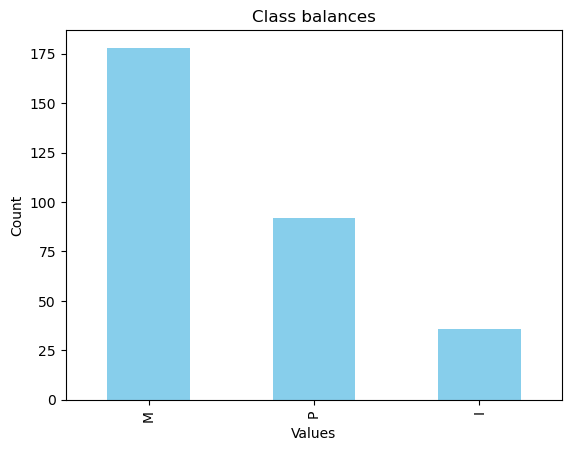

In [32]:
import matplotlib.pyplot as plt

df = tooth_labels
value_counts = df['tooth_type'].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

In [33]:
# get fraction of most frequent class
fraction = (tooth_labels['tooth_type'] == 'M').astype('int').sum() / len(tooth_labels)
fraction

0.5816993464052288

## Fix class imbalance

Baseline (test something): shift each P to the left by 5 pixels

In [34]:
value_counts

tooth_type
M    178
P     92
I     36
Name: count, dtype: int64

In [35]:
# each I to 6 images, each P to 2 images
image_path = '/home/riikoro/fossil_data/tooth_samples'

def translation_augment(tooth_type, tx, ty):
    translated_images = []
    translation_matrix = np.array([[1.,0.,tx],[0.,1.,ty]])
    for i, p_row in tooth_labels[tooth_labels['tooth_type'] == tooth_type].iterrows():
        image = cv2.imread(f'{image_path}/v{p_row["data_v"]}/{p_row["image_i"]}.png', cv2.IMREAD_GRAYSCALE)
        height, width = image.shape[:2]
        translated_image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height), borderMode=cv2.BORDER_CONSTANT,borderValue=255)
        translated_images.append(translated_image)
    return translated_images

new_Ps = translation_augment('P', -2., 1.)
new_Is = []
translations = [(-7,1), (-4,1), (1, -4), (1, 4)]
for i in range(4): # translate each image 5 times to obtain enough incisors
    new = translation_augment('I', translations[i][0], translations[i][1])
    new_Is.extend(new)


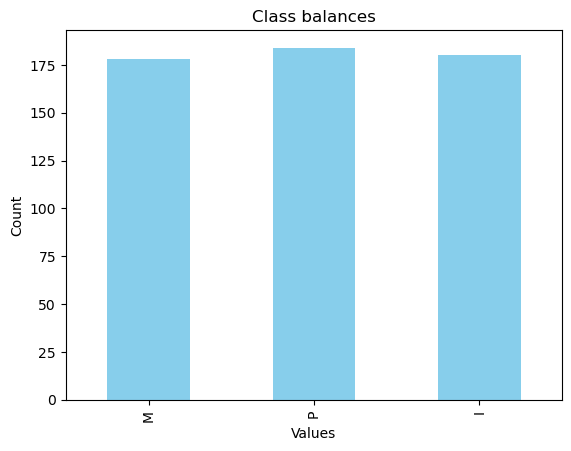

In [36]:
# re-plot histogram
value_counts = df['tooth_type'].value_counts()
value_counts['P'] += len(new_Ps)
value_counts['I'] += len(new_Is)

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

In [37]:
# update most frequent fraction
fraction = value_counts.max() / value_counts.sum()
fraction

0.33948339483394835

In [40]:
count_of_trained_layers = 2
for layer in mnist_model.layers[:-1*count_of_trained_layers]:
    layer.trainable = False

new_output = Dense(3, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_2, built=True>]

In [41]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
True
True


In [42]:
def preprocess_img(sample):
    sample = 255-sample
    sample = cv2.GaussianBlur(sample, (5, 5), 0)
    _, sample = cv2.threshold(sample, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    final = cv2.resize(sample,(28,28), interpolation = cv2.INTER_AREA)
    return final

In [43]:
versions = [3,4,5]
img_globs = []
for v in versions:
    img_globs.append(glob.glob(f"/home/riikoro/fossil_data/tooth_samples/v{v}/*.png"))

In [44]:
tooth_images = []
for i, label in tooth_labels.iterrows():
    filename = f'{image_path}/v{label["data_v"]}/{label["image_i"]}.png'
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    tooth_images.append(image)


# add augmented images
tooth_images.extend(new_Ps)
tooth_images.extend(new_Is)
preprocessed_images = list(map(preprocess_img, tooth_images))

teeth = np.array(preprocessed_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1) # add rgb dimension, required by model
teeth.shape

(542, 28, 28, 1)

In [45]:
# convert labels dataframe to have m p i vector instead of letter
labels = pd.DataFrame()
labels['m'] = (tooth_labels['tooth_type'] == 'M').astype('int')
labels['p'] = (tooth_labels['tooth_type'] == 'P').astype('int')
labels['i'] = (tooth_labels['tooth_type'] == 'I').astype('int')
labels_no_aug = labels.reset_index(drop=True)
labels_no_aug

,m,p,i
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
301,0,0,1
302,0,0,1
303,0,0,1
304,0,0,1


In [46]:
# append labels for images obtained with data augmentation
p = pd.DataFrame([[0,1,0]], columns=['m', 'p', 'i'])
new_ps = p.loc[p.index.repeat(len(new_Ps))]

i = pd.DataFrame([[0,0,1]], columns=['m', 'p', 'i'])
new_is = i.loc[i.index.repeat(len(new_Is))]

labels = pd.concat((labels,new_ps,new_is), axis=0).reset_index(drop=True)
labels

,m,p,i
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
537,0,0,1
538,0,0,1
539,0,0,1
540,0,0,1


In [47]:

X_train, X_val, Y_train, Y_val = train_test_split(teeth, labels, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(487, 28, 28, 1) (55, 28, 28, 1) (487, 3) (55, 3)


In [48]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 8 # in each iteration, we consider 128 training examples at once
num_epochs = 50
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [49]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = num_epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 - 1s - 21ms/step - accuracy: 0.3820 - loss: 1.3686 - val_accuracy: 0.4727 - val_loss: 122.2497 - learning_rate: 0.0010
Epoch 2/50
60/60 - 0s - 861us/step - accuracy: 0.6250 - loss: 0.9834 - val_accuracy: 0.5091 - val_loss: 122.5074 - learning_rate: 0.0010
Epoch 3/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/home/riikoro/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 - 0s - 8ms/step - accuracy: 0.4468 - loss: 1.2601 - val_accuracy: 0.5273 - val_loss: 99.7258 - learning_rate: 0.0010
Epoch 4/50
60/60 - 0s - 834us/step - accuracy: 0.3750 - loss: 1.2116 - val_accuracy: 0.5273 - val_loss: 100.0341 - learning_rate: 0.0010
Epoch 5/50
60/60 - 0s - 7ms/step - accuracy: 0.5365 - loss: 1.0316 - val_accuracy: 0.6182 - val_loss: 78.6715 - learning_rate: 0.0010
Epoch 6/50
60/60 - 0s - 781us/step - accuracy: 0.7500 - loss: 0.6763 - val_accuracy: 0.6182 - val_loss: 78.5888 - learning_rate: 0.0010
Epoch 7/50
60/60 - 0s - 7ms/step - accuracy: 0.5115 - loss: 1.0526 - val_accuracy: 0.6545 - val_loss: 71.9981 - learning_rate: 0.0010
Epoch 8/50
60/60 - 0s - 906us/step - accuracy: 0.6250 - loss: 1.2274 - val_accuracy: 0.6545 - val_loss: 72.0697 - learning_rate: 0.0010
Epoch 9/50
60/60 - 0s - 7ms/step - accuracy: 0.5449 - loss: 0.9854 - val_accuracy: 0.7273 - val_loss: 68.3350 - learning_rate: 0.0010
Epoch 10/50
60/60 - 0s - 866us/step - accuracy: 0.3750 - loss: 1.3

2024-10-07 15:05:35.298463: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 - 0s - 8ms/step - accuracy: 0.6472 - loss: 0.8061 - val_accuracy: 0.7636 - val_loss: 51.7111 - learning_rate: 0.0010
Epoch 16/50
60/60 - 0s - 956us/step - accuracy: 0.3750 - loss: 0.9476 - val_accuracy: 0.7636 - val_loss: 51.6824 - learning_rate: 0.0010
Epoch 17/50
60/60 - 0s - 7ms/step - accuracy: 0.6409 - loss: 0.8151 - val_accuracy: 0.7455 - val_loss: 61.1057 - learning_rate: 0.0010
Epoch 18/50
60/60 - 0s - 890us/step - accuracy: 0.5000 - loss: 1.2395 - val_accuracy: 0.7455 - val_loss: 60.7548 - learning_rate: 0.0010
Epoch 19/50
60/60 - 0s - 8ms/step - accuracy: 0.6785 - loss: 0.7754 - val_accuracy: 0.8000 - val_loss: 42.6432 - learning_rate: 0.0010
Epoch 20/50
60/60 - 0s - 890us/step - accuracy: 0.5000 - loss: 0.9069 - val_accuracy: 0.8000 - val_loss: 42.3483 - learning_rate: 0.0010
Epoch 21/50
60/60 - 0s - 7ms/step - accuracy: 0.6743 - loss: 0.7503 - val_accuracy: 0.8182 - val_loss: 39.3630 - learning_rate: 0.0010
Epoch 22/50
60/60 - 0s - 839us/step - accuracy: 0.5000 - loss

In [50]:
loss, acc = model.evaluate(X_train, Y_train, verbose=1)
acc

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9007 - loss: 0.3331


0.8911704421043396

In [51]:
test_loss, test_acc = model.evaluate(X_val, Y_val)
test_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8614 - loss: 33.6445


0.8545454740524292

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

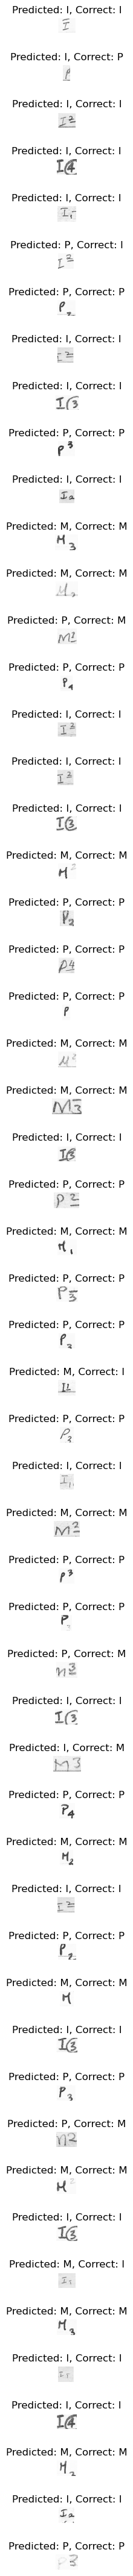

In [52]:
def id_to_tooth(id):
    if id == 0:
        return 'M'
    elif id == 1:
        return 'P'
    elif id == 2:
        return 'I'

correct = 0
test_data_size = X_val.shape[0]
fig, ax = plt.subplots(test_data_size, figsize= (200, test_data_size))
plt.subplots_adjust(hspace=2)
for i, img_i in enumerate(Y_val.index):
    # img_data = tooth_labels.iloc[img_i]
    # v = img_data['data_v']
    # image_no = img_data['image_i']
    image = tooth_images[img_i]

    label_i = Y_val.loc[img_i]
    label = id_to_tooth(np.argmax(label_i))

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred_tooth = id_to_tooth(np.argmax(pred))
    correct_tooth = label
    fig_title = f'Predicted: {pred_tooth}, Correct: {correct_tooth}'
    if pred_tooth == correct_tooth:
        correct += 1

    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

print(f'Accuracy: {correct/test_data_size}')

In [53]:
# save pretrained model
model.save('MPI.keras')

In [54]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment("MPIC")

params = {
    'data_v': 3,
    'train_size': X_train.shape[0],
    'test_size': X_val.shape[0],
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'base_model_path': base_model_path,
    'preprocessing': 'color flip, Gaussian blur kernel size 5, Otsu threshold, area interpolation resizing',
    'layers_trained': count_of_trained_layers
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", acc)
    mlflow.log_metric("test accuracy", test_acc)

    mlflow.log_artifact('MPI.keras')

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Fixed labels shuffling bug, trained last 2 layers")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
